In [1]:
import fastf1
from fastf1 import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [2]:
from fastf1.utils import delta_time
import fastf1.plotting

req            INFO 	Using cached data for driver_info


'#ff8000'

## Data

In [3]:
session = fastf1.get_session(2025,'Monaco','Q')
session.load(laps=True, weather=True, telemetry=True)

req         WARNING 	DEFAULT CACHE ENABLED! (2.34 GB) C:\Users\Sanket\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api          

## Practice Analysis

## Qualifying Analysis

In [38]:
session.laps[['Driver','LapTime','LapNumber','Stint']]

,Driver,LapTime,LapNumber,Stint
0,NOR,0 days 00:01:47.078000,1.0,1.0
1,NOR,0 days 00:01:12.860000,2.0,1.0
2,NOR,0 days 00:01:39.170000,3.0,1.0
3,NOR,0 days 00:01:11.596000,4.0,1.0
4,NOR,0 days 00:01:33.901000,5.0,1.0
...,...,...,...,...
428,COL,0 days 00:01:44.643000,8.0,2.0
429,COL,0 days 00:01:12.815000,9.0,2.0
430,COL,0 days 00:01:36.366000,10.0,2.0
431,COL,0 days 00:01:12.597000,11.0,2.0


In [4]:
q1,q2,q3 = session.laps.split_qualifying_sessions()
q1 = q1.pick_accurate()
q2 = q2.pick_accurate()
q3 = q3.pick_accurate()

In [5]:
p1 = 'NOR'
p2 = 'LEC'

### P1,P2 Comparison

In [6]:
d_p1 = q3.pick_driver(p1).pick_fastest().get_telemetry(frequency=20).add_distance()
d_p2 = q3.pick_driver(p2).pick_fastest().get_telemetry(frequency=20).add_distance()

In [7]:
delta_time, ref_tel, compare_tel = utils.delta_time(q3.pick_driver(p1).pick_fastest(), q3.pick_driver(p2).pick_fastest())

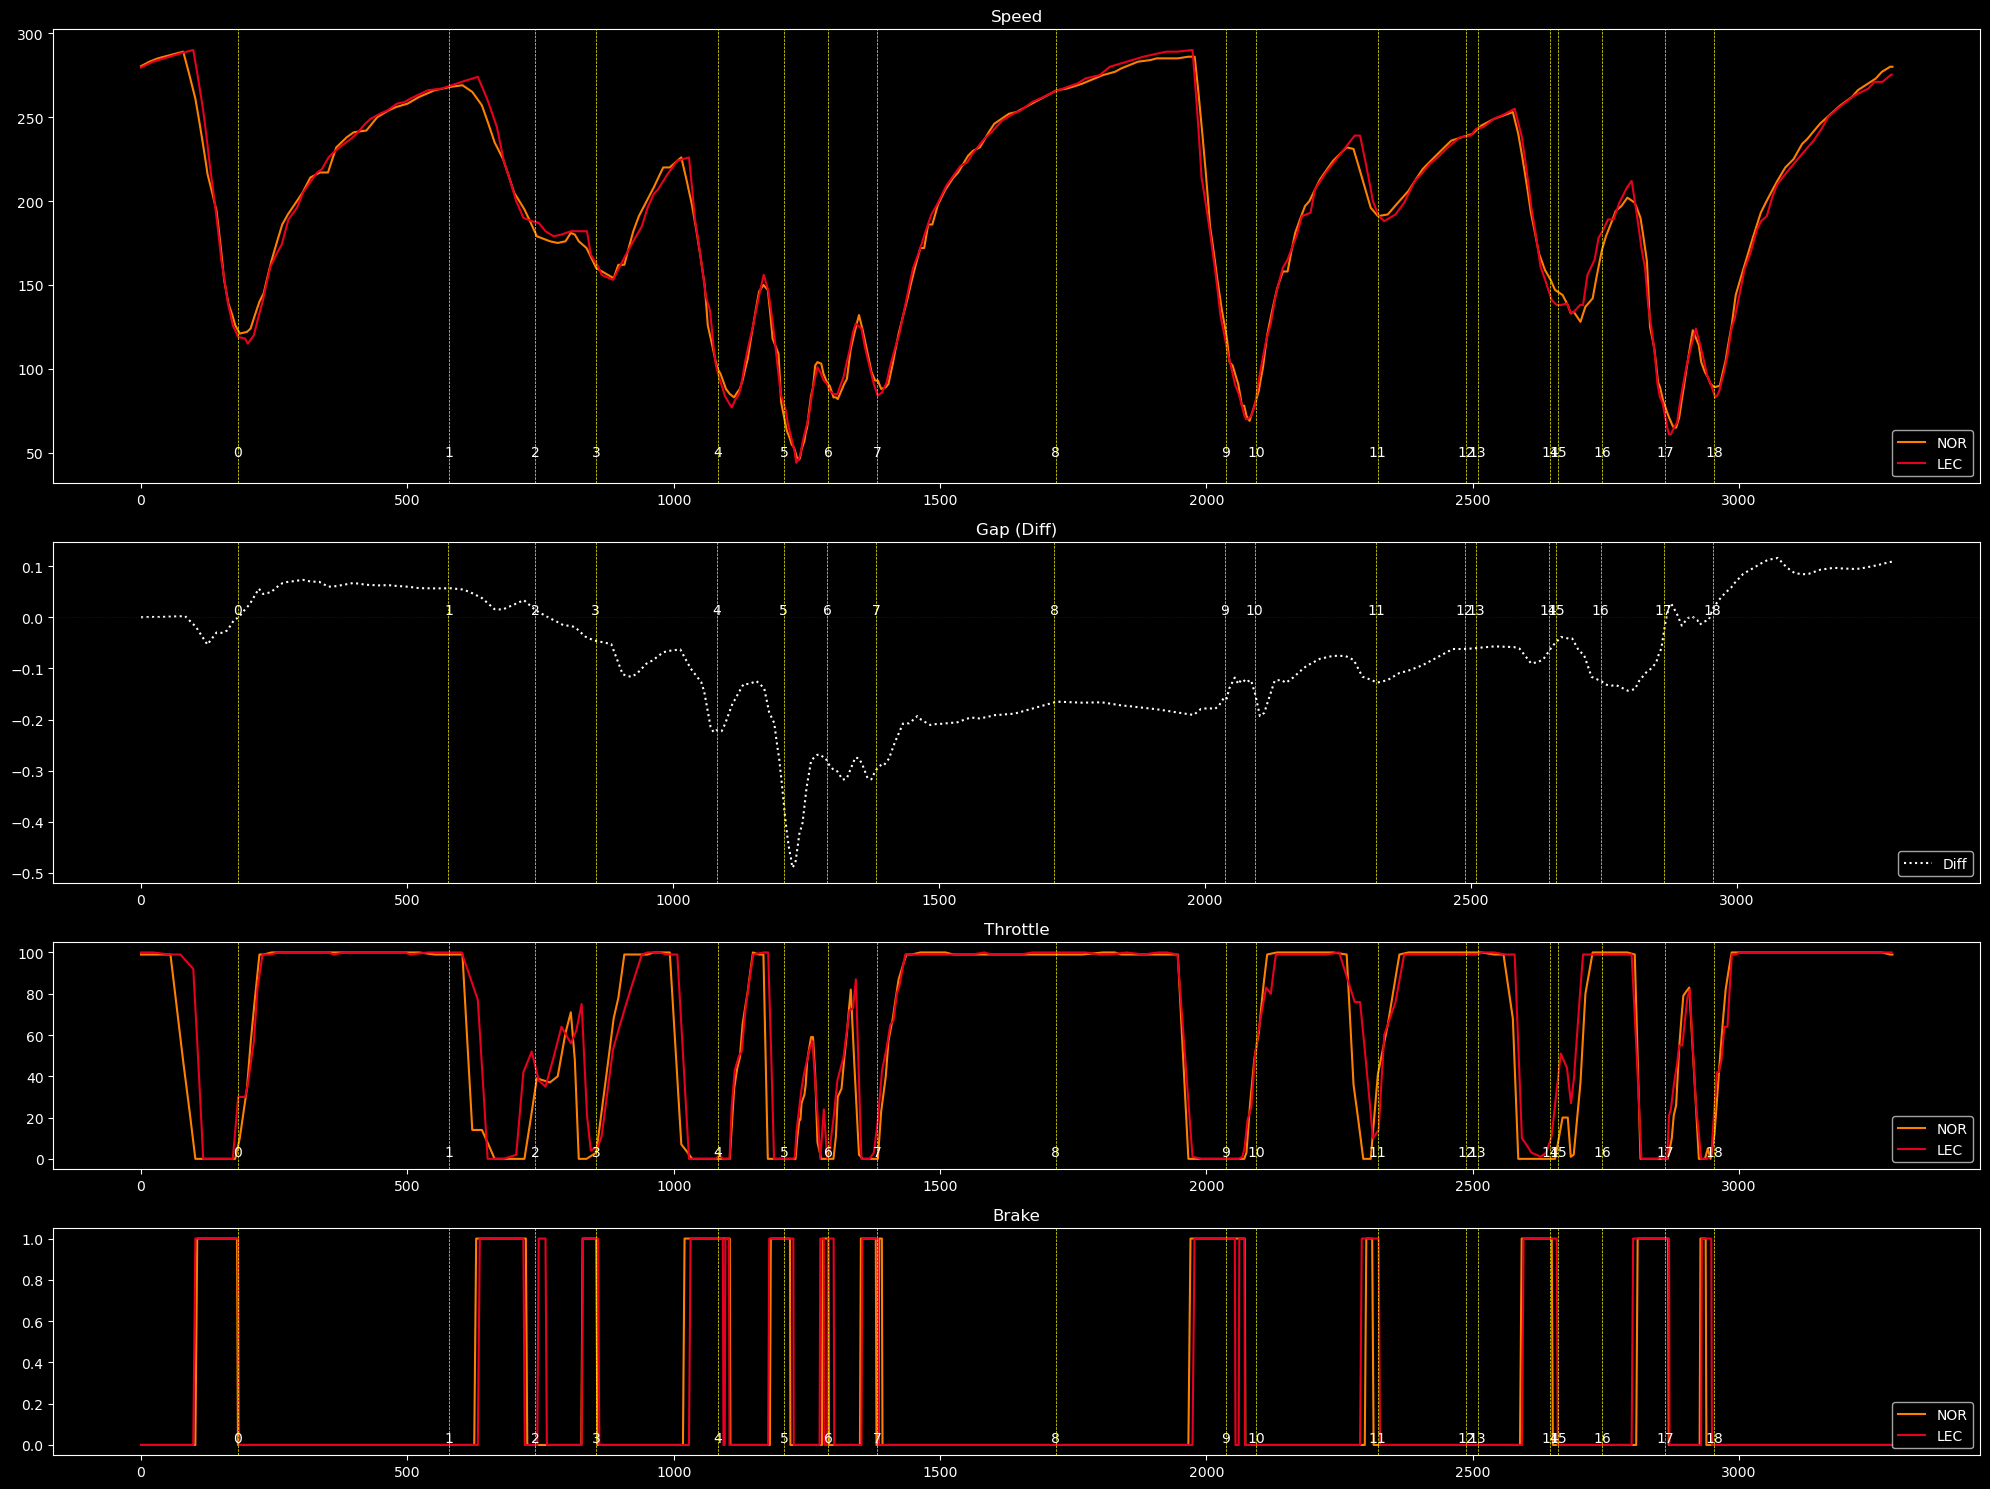

In [30]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.75, 0.5, 0.5])  # Define grid with different heights


# Speed Plot
ax0 = fig.add_subplot(gs[0])
ax0.plot(d_p1['Distance'], d_p1['Speed'], label=p1, color=fastf1.plotting.get_driver_color(p1,session=session))
ax0.plot(d_p2['Distance'], d_p2['Speed'], label=p2, color=fastf1.plotting.get_driver_color(p2,session=session))
for corner_index in range(len(session.get_circuit_info().corners)):
    ax0.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax0.text(session.get_circuit_info().corners['Distance'][corner_index], session.laps.pick_fastest().get_telemetry().Speed.min(), f'{corner_index}', ha='center', va='bottom')
ax0.legend(loc='lower right')
ax0.set_title("Speed")

# Gap (Diff) Plot
ax1 = fig.add_subplot(gs[1])
ax1.plot(ref_tel['Distance'],delta_time, label='Diff', color='white',linestyle='dotted')
ax1.axhline(y=0, color='blue', linestyle='dotted', linewidth=0.5)
for corner_index in range(len(session.get_circuit_info().corners)):
    ax1.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax1.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax1.legend(loc='lower right')
ax1.set_title("Gap (Diff)")

# Throttle Plot
ax2 = fig.add_subplot(gs[2])
ax2.plot(d_p1['Distance'], d_p1['Throttle'], label=p1, color=fastf1.plotting.get_driver_color(p1,session=session))
ax2.plot(d_p2['Distance'], d_p2['Throttle'], label=p2, color=fastf1.plotting.get_driver_color(p2,session=session))
for corner_index in range(len(session.get_circuit_info().corners)):
    ax2.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax2.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax2.legend(loc='lower right')
ax2.set_title("Throttle")

# Brake Plot
ax3 = fig.add_subplot(gs[3])
ax3.plot(d_p1['Distance'], d_p1['Brake'], label=p1, color=fastf1.plotting.get_driver_color(p1,session=session))
ax3.plot(d_p2['Distance'], d_p2['Brake'], label=p2, color=fastf1.plotting.get_driver_color(p2,session=session))
for corner_index in range(len(session.get_circuit_info().corners)):
    ax3.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax3.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax3.legend(loc='lower right')
ax3.set_title("Brake")

plt.tight_layout()
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_P1P2Comparison')

plt.show()

-- Discussions


- Leclerc was mighty in the first sector where he had gained almost 0.5 sec of gap over Norris but the mclaren consistently regained the time in the 2nd and 3rd Sector. Leclerc might have used up a bit of tyre in the 1st Sector and was eager on throttle in 1st Sector. After the end of 1st Sector, Leclerc was more probable of taking the pole.

### Car Setups

In [70]:
car_setups = []

In [71]:
for i in session.drivers:
    try:
        car_setups.append([i,session.get_driver(i)['TeamName'],session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.mean(),session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.max()])
    except:
        pass

In [ ]:
car_setups = pd.DataFrame(car_setups,columns=['Driver','Team','MeanSpeed','TopSpeed'])
car_setups['SpeedRatio'] = car_setups['MeanSpeed']/car_setups['TopSpeed']
car_setups['SpeedRatio'] = car_setups['SpeedRatio'].apply(lambda x : np.round(x,3))


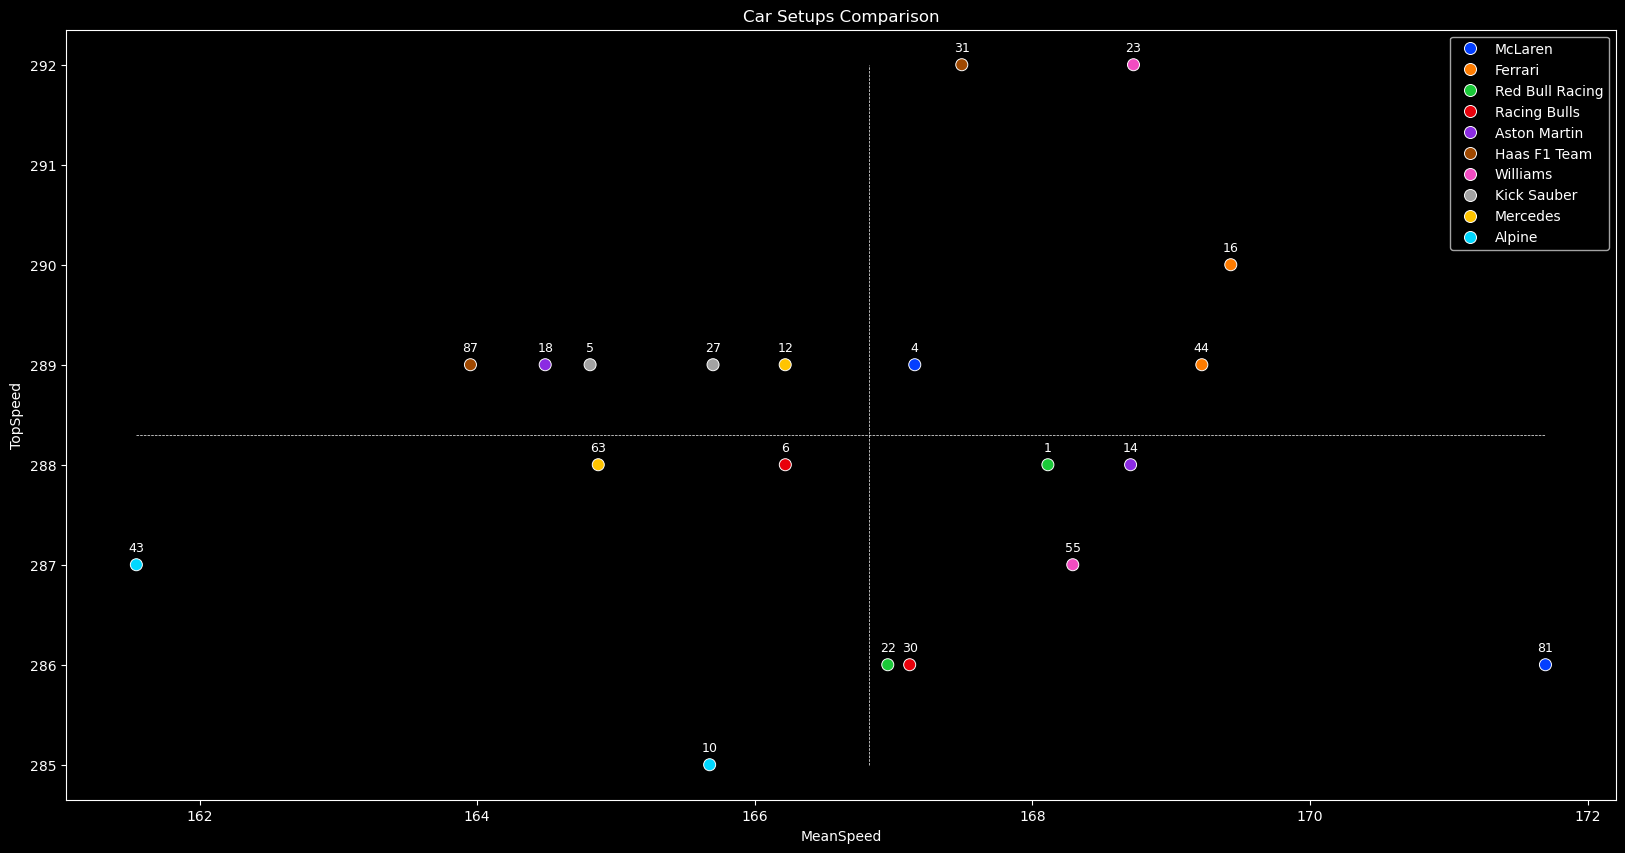

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=car_setups,x='MeanSpeed',y='TopSpeed',hue='Team',palette='bright',s=75)
plt.hlines(car_setups['TopSpeed'].mean(),xmin=car_setups['MeanSpeed'].min(),xmax=car_setups['MeanSpeed'].max(),linestyles='dashed',linewidth=0.5)
plt.vlines(car_setups['MeanSpeed'].mean(),ymin=car_setups['TopSpeed'].min(),ymax=car_setups['TopSpeed'].max(),linestyles='dashed',linewidth=0.5)

for _, row in car_setups.iterrows():
    plt.text(row['MeanSpeed'], row['TopSpeed']+0.1, f'{row['Driver']}', fontsize=9, ha='center', va='bottom')

plt.legend()
plt.title('Car Setups Comparison')
# plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_CarSetups.png')

plt.show()

-- Discussions

- Ferrari looks mighty with the car setup where the Mean Speed is quite high
- Piastri (Car 81) is the outlier with exceptional mean speed
- Ocon (Car 31) and Albon (Car 23) are outliers with higher Top Speeds
- Colapinto (Car 43) is also an outlier with extremely low mean speed and top speed suggesting a low confidence in the car or weak car setup

## Race Analysis

### LapTime Boxplots

In [5]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [ ]:
data = pd.DataFrame(session.laps.pick_accurate())[['Driver', 'LapNumber','Compound','LapTime']].sort_values()

In [13]:
data['LapTime'] = data['LapTime'].dt.total_seconds()

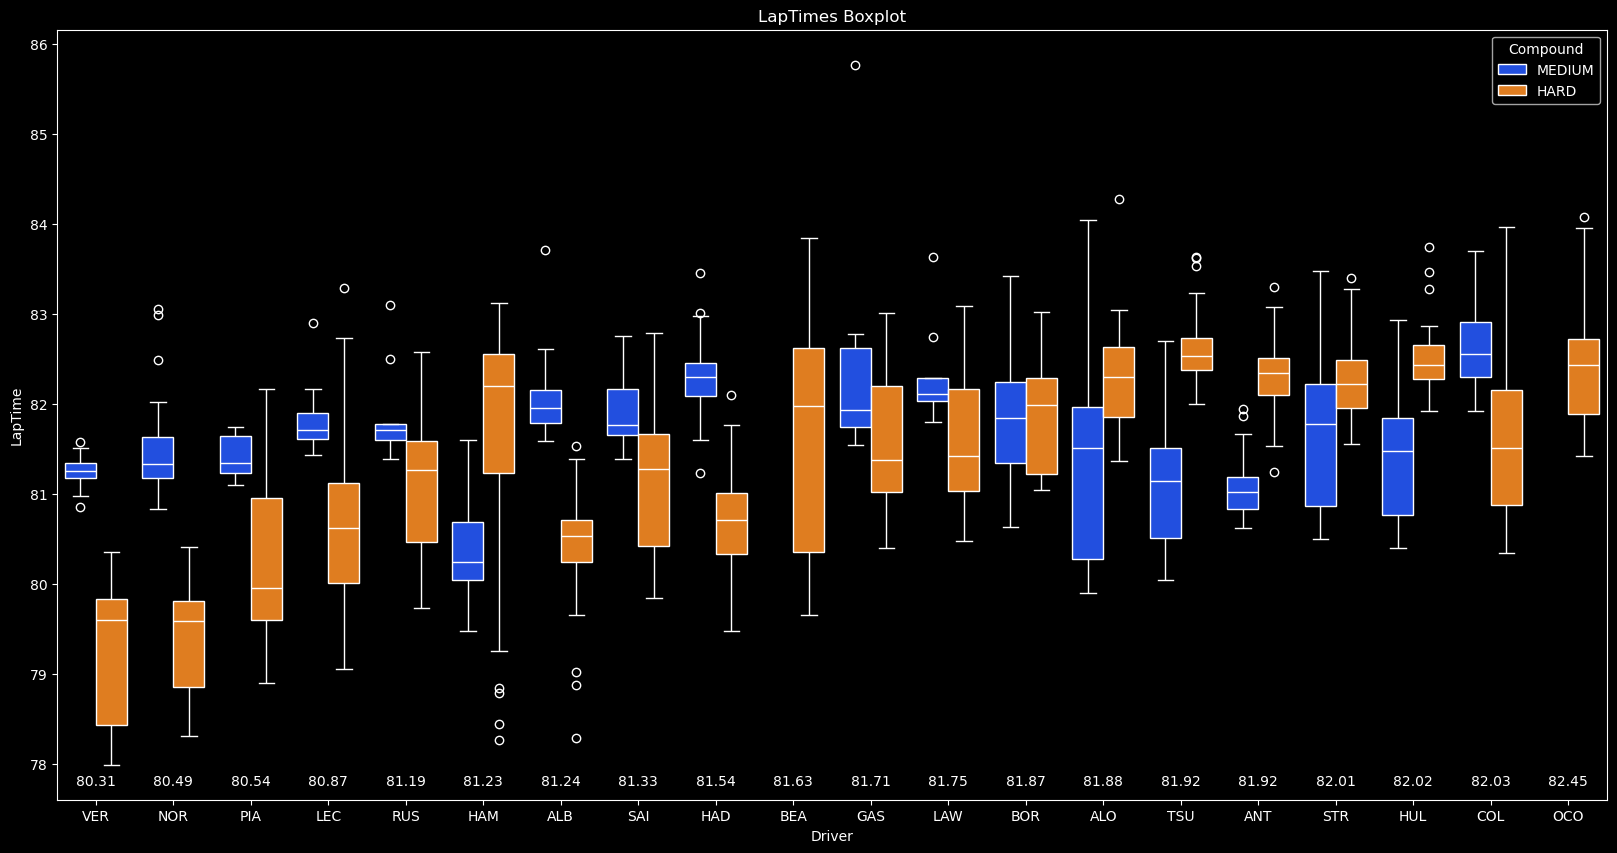

In [123]:
driver_order = data.groupby('Driver')['LapTime'].mean().sort_values().index
mean_lap_times = data.groupby('Driver')['LapTime'].mean()

plt.figure(figsize=(20,10))
sns.set_palette("bright")
sns.boxplot(data=data,x='Driver',y='LapTime',hue='Compound',order=driver_order,linecolor='white')

for i, driver in enumerate(driver_order):
    plt.text(i,77.72, f"{mean_lap_times[driver]:.2f}", 
             ha='center', va='bottom', fontsize=10, color='white')
    
plt.title('LapTimes Boxplot')
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_LapTimes')

### 0 - 200 acceleration

In [ ]:
zero_twohundred = []

for i in session.drivers:
    tel = session.laps.pick_driver(i).pick_lap(1).get_telemetry()
    lap_time_sec = tel[tel['Distance'] < 40]['Time'][-2:-1].dt.total_seconds().values
    if len(lap_time_sec) > 0:
        zero_twohundred.append([i, lap_time_sec[0]])
    else:
        zero_twohundred.append([i, None])

zero_hundred = pd.DataFrame(zero_twohundred,columns=['Driver','Acceleration']).sort_values('Acceleration')

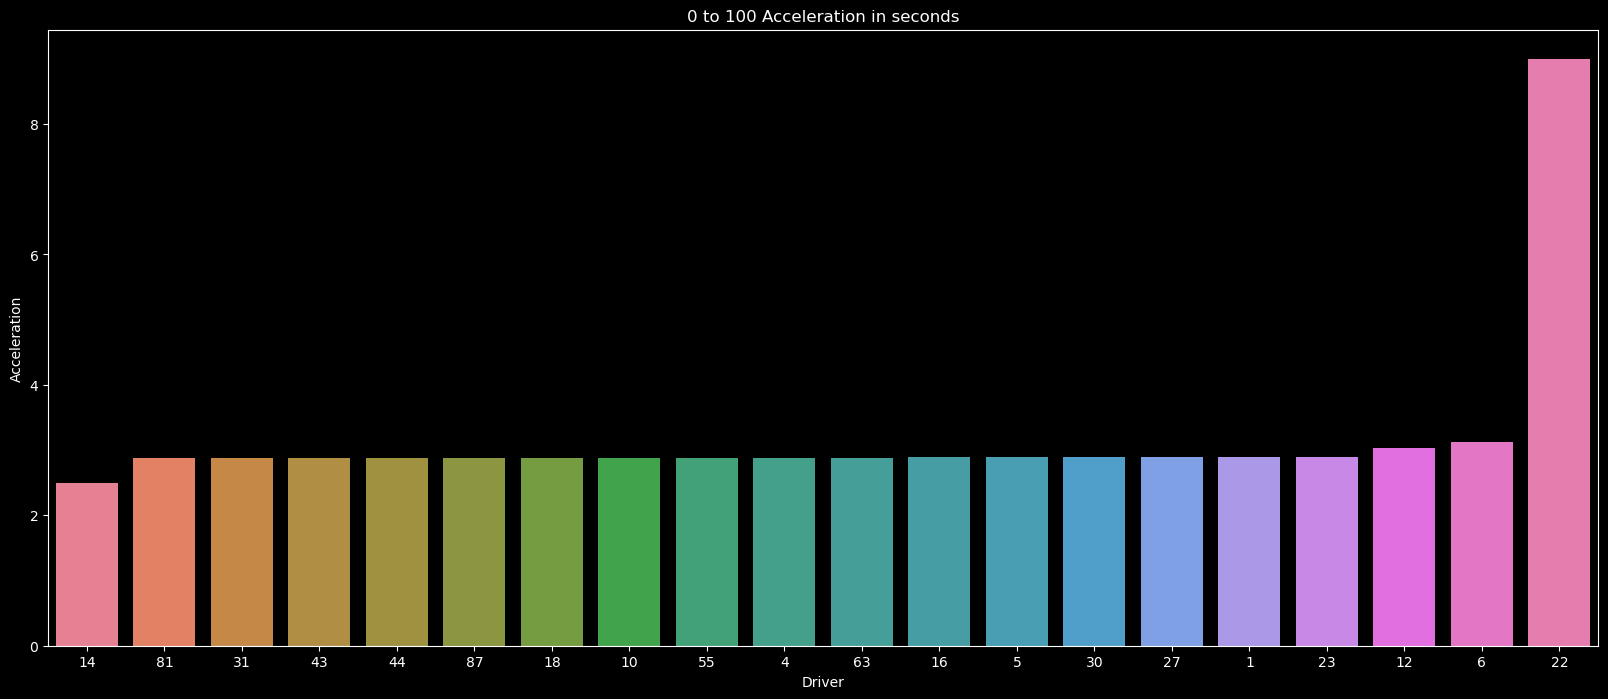

In [ ]:
# Sort by Acceleration (ascending)
plt.figure(figsize=(20,8))
sns.barplot(data=zero_twohundred, x='Driver', y='Acceleration',hue='Driver')


plt.title('0 to 100 Acceleration in seconds')

plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_ZeroHundred_Comparison')